In [31]:

# Importing necessary libraries
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import re
import nltk

# Downloading stopwords if not already downloaded
nltk.download('stopwords')

# Read dataset
dataset = pd.read_csv('Restaurant_Review.tsv', delimiter='\t', quoting=3)

# Preprocessing the dataset
corpus = []
for review in dataset['Review']:
    review = re.sub('[^a-zA-Z]', ' ', review)  # Removing non-alphabetic characters
    review = review.lower().split()  # Converting text to lowercase and splitting into words
    ps = nltk.PorterStemmer()  # Creating a PorterStemmer object for word stemming
    review = [ps.stem(word) for word in review if word not in set(nltk.corpus.stopwords.words('english'))]  # Stemming words and removing stopwords
    review = ' '.join(review)  # Joining the words back into a sentence
    corpus.append(review)  # Appending the preprocessed review to the corpus list

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
X = tfidf_vectorizer.fit_transform(corpus)
y = dataset['Liked']

# Splitting dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers along with their parameter grids for grid search
classifiers = {
    "Multinomial Naive Bayes": (MultinomialNB(), {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}),
    "Logistic Regression": (LogisticRegression(), {'C': [0.1, 1.0, 10.0, 100.0]}),
    "SVC": (SVC(), {'C': [0.1, 1.0, 10.0, 100.0], 'kernel': ['linear', 'rbf', 'poly']}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [50, 100, 200]})
}

# Perform grid search with cross-validation for each model
for name, (classifier, param_grid) in classifiers.items():
    grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    # Print the best hyperparameters found
    print(f"\n{name}:")
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Cross-Validation Accuracy:", grid_search.best_score_*100)
    
    # Extract and print the accuracy score of the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy of Best Model on Test Set:", accuracy*100)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svhar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Multinomial Naive Bayes:
Best Hyperparameters: {'alpha': 1.5}
Best Cross-Validation Accuracy: 78.625
Accuracy of Best Model on Test Set: 75.5


H:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression:
Best Hyperparameters: {'C': 10.0}
Best Cross-Validation Accuracy: 79.12500000000001
Accuracy of Best Model on Test Set: 74.5

SVC:
Best Hyperparameters: {'C': 10.0, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 79.0
Accuracy of Best Model on Test Set: 75.0

Random Forest:
Best Hyperparameters: {'n_estimators': 100}
Best Cross-Validation Accuracy: 78.25
Accuracy of Best Model on Test Set: 70.0


In [54]:
# Train Multinomial Naive Bayes classifier with best hyperparameters
best_mnb = MultinomialNB(alpha=best_params['alpha'])
best_mnb.fit(X_train, y_train)

def predict_sentiment_multinomial(sample_review):
    # Preprocess the sample review
    review = re.sub('[^a-zA-Z]', ' ', sample_review)  # Removing non-alphabetic characters
    review = review.lower().split()  # Converting text to lowercase and splitting into words
    ps = nltk.PorterStemmer()  # Creating a PorterStemmer object for word stemming
    review = [ps.stem(word) for word in review if word not in set(nltk.corpus.stopwords.words('english'))]  # Stemming words and removing stopwords
    review = ' '.join(review)  # Joining the words back into a sentence
    
    # Convert the preprocessed review into a numerical vector using TF-IDF Vectorizer
    sample_vector = tfidf_vectorizer.transform([review])
    
    # Predict the sentiment using the trained Multinomial Naive Bayes classifier
    sentiment_prediction = best_mnb.predict(sample_vector)[0]
    
    # Return the predicted sentiment (1 for positive, 0 for negative)
    return "Positive" if sentiment_prediction == 1 else "Negative"

# Sample review for prediction
sample_review = "The food is wow!"

# Predicting sentiment of sample review using Multinomial Naive Bayes classifier
prediction_multinomial = predict_sentiment_multinomial(sample_review)
print("Sentiment Prediction for Sample Review (Multinomial Naive Bayes):", prediction_multinomial)


Sentiment Prediction for Sample Review (Multinomial Naive Bayes): Positive


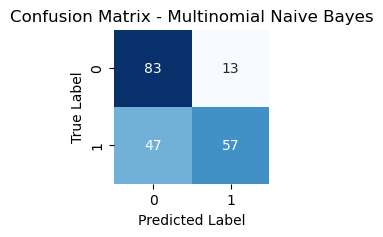

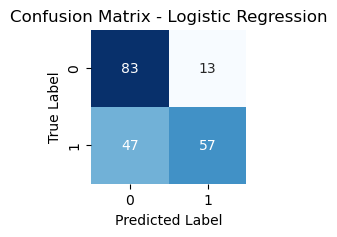

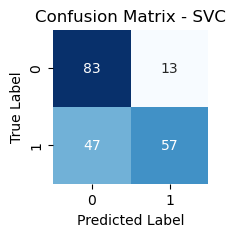

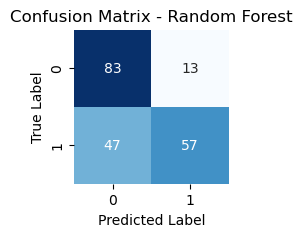

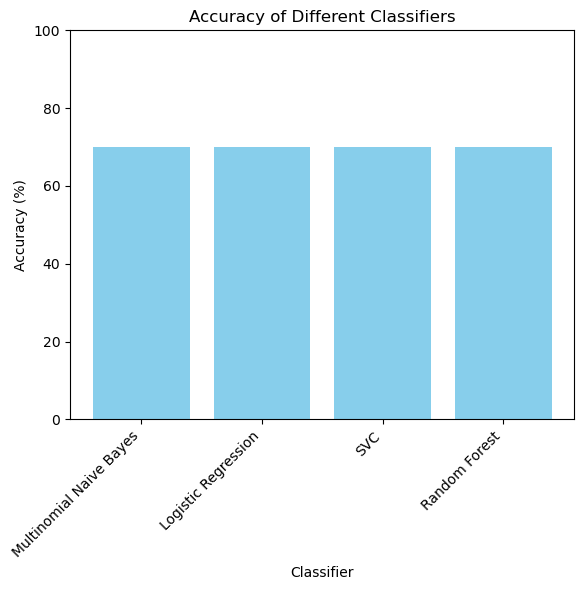

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Lists to store model names and corresponding accuracy scores
model_names = []
accuracy_scores = []

# Iterate over classifiers and their best models
for name, (classifier, param_grid) in classifiers.items():
    # Get the best model from grid search
    best_model = grid_search.best_estimator_
    
    # Predict on test set
    y_pred = best_model.predict(X_test)
    
    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append model name and accuracy score to lists
    model_names.append(name)
    accuracy_scores.append(accuracy*100)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(2, 2))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot accuracy graph
plt.figure(figsize=(6, 6))
plt.bar(model_names, accuracy_scores, color='skyblue')
plt.xlabel('Classifier')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Different Classifiers')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()
